In [14]:
# Module: packages.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from PIL import Image
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array




In [15]:
# Pfade zu den Daten
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'

In [16]:

def load_data_scaling(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    

    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape((-1,1))).reshape((*X_train.shape,1))
    X_test_scaled = scaler.transform(X_test.reshape((-1,1))).reshape(*(X_test.shape),1)
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape((-1,1))).reshape((*y_train.shape,1))
    y_test_scaled = scaler.transform(y_test.reshape((-1,1))).reshape(*(y_test.shape),1)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler

In [17]:
#val loss 9,3 für das folgende modell, best so far
# Module: model.py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def build_and_train_model(X_train, y_train, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'):
    # Füge eine Dimension für die Kanäle hinzu (falls notwendig)
    if len(X_train.shape) == 3:
        X_train = X_train[..., np.newaxis]
       
    model = Sequential([
        # Erste Convolutional Schicht
        Conv2D(128, (3, 3), activation='relu', input_shape=(196, 256, 1)),
        MaxPooling2D((2, 2)),
        
        # Zweite Convolutional Schicht
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Dritte Convolutional Schicht
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Vierte Convolutional Schicht
        Conv2D(512, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fünfte Convolutional Schicht (optional)
        Conv2D(1024, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        

        # Flatten-Schicht
        Flatten(),
        
        # Dense Schicht
        Dense(256, activation='relu'),
        Dropout(0.4),
        
        # Output-Schicht
        Dense(1)
    ])

    # Kompiliere das Modell
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5)
    
    # Trainiere das Modell
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_split=0.15,
                    callbacks=[early_stopping, reduce_lr])

    # Speichern des Modells
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    
    return model, history


In [18]:
# Module: evaluation.py

### zzzzz
def load_trained_model(model_save_path):
    # Modell laden
    model = load_model(model_save_path)
    return model

def evaluate_model(model_path, X_test, y_test, scaler):
    # Modell laden
    try:
        model = load_model(model_path)
        print("Model successfully loaded.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Überprüfen Sie die Eingabeformate
    print("Shape von X_test beim Modellbewerten:", X_test.shape)
    print("Shape von y_test beim Modellbewerten:", y_test.shape)

    # Model evaluieren
    try:
       # loss = model.evaluate(X_test, y_test)
        ypred = model.predict(X_test)
        ypred = scaler.inverse_transform(ypred)
    except Exception as e:
        print(f"Error evaluating model: {e}")

    # zurückscalen von ytets
    y_test = scaler.inverse_transform(y_test)

    # scatterplot 
    if len(ypred) == len(y_test):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, ypred, alpha=0.5)
        plt.xlabel('Handgemessene Werte')
        plt.ylabel('Vorhergesagte Werte')
        plt.title('Vergleich der handgemessenen Werte mit den Vorhersagen des Modells')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.show()

        # Berechnung der Metriken
        mae = mean_absolute_error(y_test, ypred)
        r2 = r2_score(y_test, ypred)
        
        # Ausgabe der Metriken
        print(f"Durchschnittliche Abweichung (MAE): {mae}")
        print(f"R²-Wert: {r2}")

    ###  Hier ypred abspeichern todo 
    #np.savetxtpath = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/ypred.txt'



c:\Users\chris\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.6239 - val_loss: 0.3814 - learning_rate: 1.0000e-04
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.3827 - val_loss: 0.2647 - learning_rate: 1.0000e-04
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.3155 - val_loss: 0.3085 - learning_rate: 1.0000e-04
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.2863 - val_loss: 0.2683 - learning_rate: 1.0000e-04
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.2627 - val_loss: 0.2242 - learning_rate: 1.0000e-04
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.2114 - val_loss: 0.1931 - learning_rate: 1.0000e-04
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.2558 - val_loss: 0.3076 - learning_rate: 1.0000e-04
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.2713 - val_loss: 0.2208 - learning_rate: 1.0000e-04
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.2328 - val_loss: 0.1905 - 

Model saved to C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1_scaled.h5
Model successfully loaded.
Shape von X_test beim Modellbewerten: (72, 256, 196, 1, 1)
Shape von y_test beim Modellbewerten: (72, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step


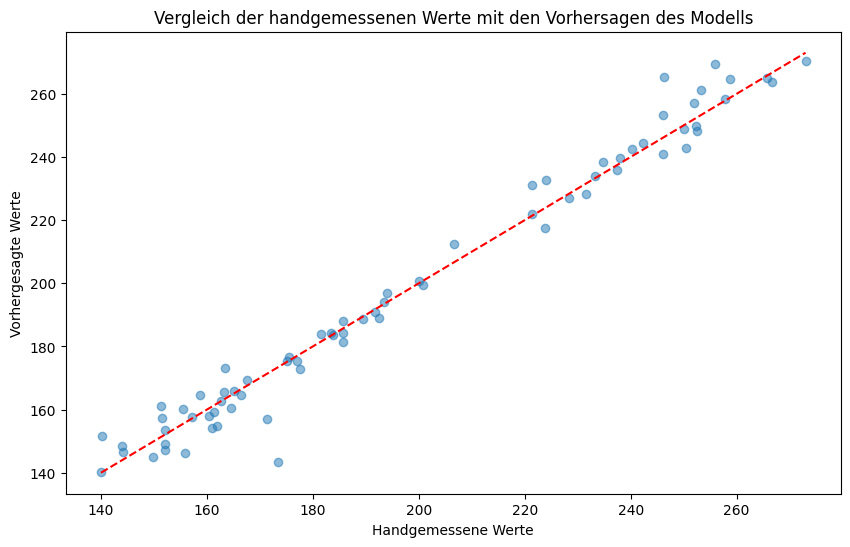

Durchschnittliche Abweichung (MAE): 4.379362682766384
R²-Wert: 0.97342355164407


In [19]:


# Daten laden
#X_train, X_test, y_train, y_test = load_data(image_dir, excel_path)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler = load_data_scaling(image_dir, excel_path)


# Modell erstellen und trainieren
#model, history = build_and_train_model(X_train, y_train, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5')
model, history = build_and_train_model(X_train_scaled, y_train_scaled, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1_scaled.h5')


# Modell bewerten
#evaluate_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5', X_test, y_test)
evaluate_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1_scaled.h5', X_test_scaled, y_test_scaled, scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

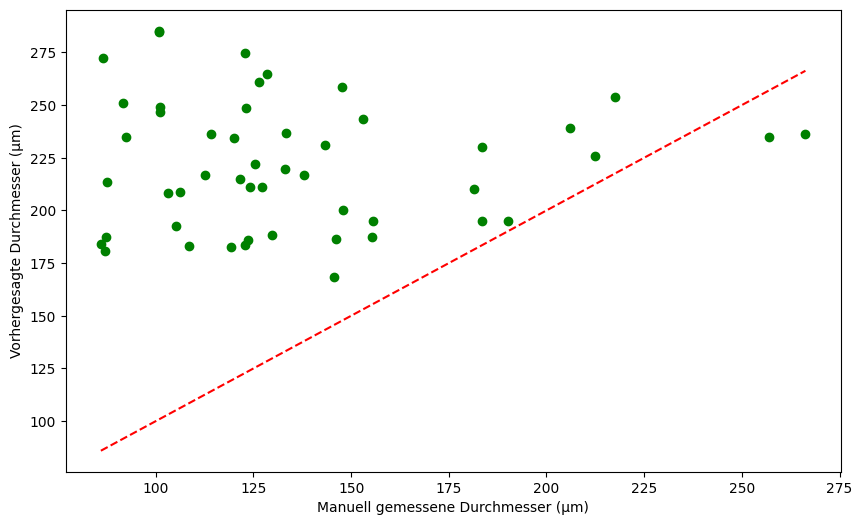

R²: -4.704857504742433 MAE: 88.05018983154295


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import mean_absolute_error, r2_score
# Pfade zu den Daten und zum Modell
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia/'
manual_data_path = 'C:/Users/chris/Documents/Testset.xlsx'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'

def load_data(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    
    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction[0][0]

def evaluate_model2(model_path, image_folder_path, manual_data_path):
    # Modell laden
    model = load_model(model_path)

    # Daten laden
    X_train, X_test, y_train, y_test = load_data(image_folder_path, manual_data_path)

    # Vorhersagen für alle Bilder im Testset
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model) for image_file in image_files]
    predictions = np.array(predictions)
    
    # Vorhersagen für das Testset
    y_test_predictions = model.predict(X_test)

    # Die erste Spalte als handgemessene Werte verwenden
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values

    # Überprüfen der Anzahl der Bilder und der Anzahl der handgemessenen Werte
    print(f"Anzahl der Bilder: {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    # Wenn die Anzahl der Vorhersagen und der manuellen Werte übereinstimmt
    if len(predictions) == len(manual_measurements):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_measurements, predictions, color="green")
        plt.xlabel('Manuell gemessene Durchmesser (µm)')
        plt.ylabel('Vorhergesagte Durchmesser (µm)')
        plt.plot([min(manual_measurements), max(manual_measurements)], [min(manual_measurements), max(manual_measurements)], color='red', linestyle='--')
        plt.show()
    else:
        print("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    mae = mean_absolute_error(manual_measurements, predictions)
    r2 = r2_score(manual_measurements, predictions)
        
        # Ausgabe der Metriken
    print(f"R²: {r2}" f" MAE: {mae}")
    
# Modell bewerten
evaluate_model2(model_path, image_folder_path, manual_data_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

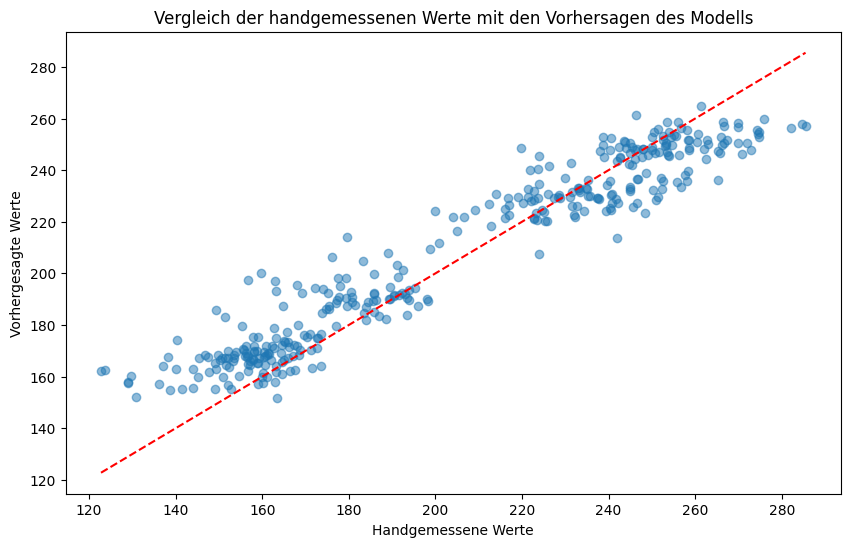

Durchschnittliche Abweichung (MAE): 10.697593361840179
R²-Wert: 0.8964943704397842


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import os

# Pfade zu den Daten und zum Modell
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
manual_data_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'



def predict_image(image_path, model, scaler):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  # Normalisiere das Bild
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    # Todo zurückscalieren
    prediction = scaler.inverse_transform(prediction)
    return prediction[0][0]


def evaluate_model(model_path, image_folder_path, manual_data_path):
    # Modell laden
    model = load_model(model_path)

    # Daten laden
    X_train, X_test, y_train, y_test, scaler = load_data(image_folder_path, manual_data_path)

    # Vorhersagen für alle Bilder im Testset
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model, scaler) for image_file in image_files]
    predictions = np.array(predictions)
    
    # Vorhersagen für das Testset
    y_test_predictions = model.predict(X_test).flatten()
    
    # Die erste Spalte als handgemessene Werte verwenden
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen der Anzahl der Bilder und der Anzahl der handgemessenen Werte
    print(f"Anzahl der Bilder: {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    # Sicherstellen, dass die Anzahl der Vorhersagen mit der Anzahl der Testwerte übereinstimmt
    if len(predictions) == len(manual_measurements):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_measurements, predictions, alpha=0.5)
        plt.xlabel('Handgemessene Werte')
        plt.ylabel('Vorhergesagte Werte')
        plt.title('Vergleich der handgemessenen Werte mit den Vorhersagen des Modells')
        plt.plot([min(manual_measurements), max(manual_measurements)], [min(manual_measurements), max(manual_measurements)], color='red', linestyle='--')
        plt.show()

        # Berechnung der Metriken
        mae = mean_absolute_error(manual_measurements, predictions)
        r2 = r2_score(manual_measurements, predictions)
        
        # Ausgabe der Metriken
        print(f"Durchschnittliche Abweichung (MAE): {mae}")
        print(f"R²-Wert: {r2}")
    else:
        print("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")

# Modell bewerten
evaluate_model(model_path, image_folder_path, manual_data_path)
